The risk can be split into two parts: 

* Individual Risk

* Dependence structure between individual risks

This notebook focuses on the second part, that is the dependence structure between individual risks: 

1) Correlations & rolling correlation calculation

2) Exceedance correlation

3) Copulas

### Setting up the notebook:

- Installing all necessary libraries
- Downloading data;
- Preparing data for further calculations

In [2]:
!pip install yfinance

     |████████████████████████████████| 6.3MB 7.7MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=63a04d3be18a3239e0779fe43f73696b6872b60bdbc011677171f428735c275c
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
!pip install arch

     |████████████████████████████████| 808kB 6.7MB/s 


In [4]:
!pip install copulas

     |████████████████████████████████| 51kB 3.0MB/s 
     |████████████████████████████████| 9.5MB 7.4MB/s 
  Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5


In [ ]:
!pip install pycopula

In [6]:
# Importing necessary libraries: 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.stats as s
import statsmodels.api as sm
import plotly.express as px
import plotly.figure_factory as ff
from arch import arch_model


from ipywidgets import HBox, VBox
from scipy.optimize import fmin, minimize
from scipy.stats import t
from scipy.stats import norm
from math import inf


from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import beta

import bs4 as bs
import requests
import datetime

#from copulalib.copulalib import Copula
#from copulae import GaussianCopula

#from copulas.bivariate import clayton

#from pycopula.copula import *
#from pycopula.visualization import cdf_2d


from copulas.multivariate import GaussianMultivariate

from copulas.visualization import compare_3d

from copulas.visualization import scatter_3d

In [7]:
# define a function that will download several stock data:

def stock_data_download(symbols, start_date, end_date):
  data_holder = dict()
  for idx in symbols:
    stock_data = yf.download(idx, start_date, end_date)
    data_holder[idx] = stock_data

  return data_holder

# Define a function that will extract necessary data from the downloaded data:
def stock_data_extract(symbols, col_name, data):
  data_holder = pd.DataFrame()
  for idx in symbols:
    data_point = data[idx][col_name]
    data_holder[idx] = data_point
  
  return data_holder

In [8]:
# Define parameters for data download: 
symbols = ['APPS', 'TLT']
start_date = '2018-01-01'
end_date = '2021-06-25'

stock_data=stock_data_download(symbols, start_date, end_date)
filtered_data = stock_data_extract(symbols, 'Adj Close', stock_data)
stock_returns = filtered_data.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Simple statistics to measure dependence between variables
- Calculating pearson correlation coefficient & covariance
- Calculating rolling coefficients


In [ ]:
# Calculating simple dependence measures: 
# Covariance between two assets' returns: 

asset_cov = stock_returns.cov()
asset_corr = stock_returns.corr()

print('Covariance matrix between ' + symbols[0] + ' and ' +  symbols[1] + 'is: ' + str(asset_cov))
print('Correlation matrix between ' + symbols[0] + ' and ' +  symbols[1] + 'is: ' + str(asset_corr))

asset_corr[symbols[0]][symbols[1]]

Covariance matrix between APPS and TLTis:           APPS       TLT
APPS  0.002415 -0.000043
TLT  -0.000043  0.000089
Correlation matrix between APPS and TLTis:           APPS       TLT
APPS  1.000000 -0.093206
TLT  -0.093206  1.000000


-0.09320567534414835

In [ ]:
# Define a function that calculates rolling correlation for two time series: 
def rolling_correlation(data, WE):
  rolling_corr = data.rolling(WE).corr(data[symbols[0]])[symbols[1]].dropna() 
  return rolling_corr



Text(0.5, 15.0, 'Date')

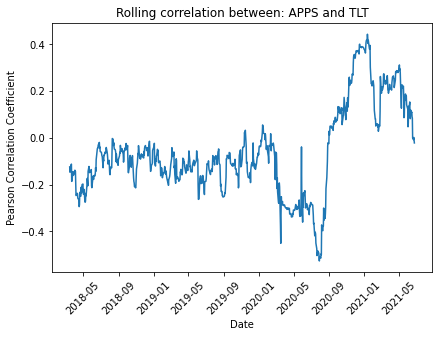

In [ ]:
WE =50
plt.plot(stock_returns.index[WE-1:], rolling_correlation(stock_returns, 50))
plt.tight_layout()
plt.xticks(rotation=45)
plt.title('Rolling correlation between: ' + symbols[0] + ' and ' + symbols[1])
plt.ylabel('Pearson Correlation Coefficient')
plt.xlabel('Date')

## Exceedance Correlation:

In [ ]:
# Define exceedance correlation function: 
def exceedance_corr2(X, Y, qc):
  corr_out = []
  k = len(qc)
  for i in range(k):
    if qc[i]<0.5:
      temp = (X[X<=X.quantile(qc[i], interpolation='linear')]*Y[Y<=Y.quantile(qc[i], interpolation='linear')]).dropna().index
      corr_coef = (X.loc[temp]).corr(Y.loc[temp])
      corr_out.append(corr_coef)
    else:
      temp = (X[X>=X.quantile(qc[i], interpolation='linear')]*Y[Y>=Y.quantile(qc[i], interpolation='linear')]).dropna().index
      corr_coef = (X.loc[temp]).corr(Y.loc[temp])
      corr_out.append(corr_coef)

  return corr_out

  # Define a function which plots pairwise exceedence correlations for a number of assets passed as a dataframe
  # NOTE, PLOT FUNCTION ONLY WORKS IF THERE ARE MORE THAN 2 ASSETS IN A DATAFRAME, IF THERE ARE ONLY 2 ASSETS PLOT IT MANUALLY!!!
def plot_exceedance_corr(data, ticker_list, qc):
  matrix_size=len(ticker_list)
  fig, axs = plt.subplots(matrix_size, matrix_size)
  fig.set_size_inches(20, 14) 
  custom_ylim = (-1, 1)
  plt.setp(axs,  ylim=custom_ylim)
  for ii in range(matrix_size):
    for jj in range(matrix_size):
      tp_1 = ticker_list[ii]
      tp_2 = ticker_list[jj]
      dp_1 = data[tp_1+'_log_return']
      dp_2 = data[tp_2+'_log_return']
      axs[ii,jj].plot(qc, exceedance_corr2(dp_1,dp_2, qc))
      axs[ii,jj].set_title(tp_1+' vs '+tp_2)

In [ ]:
qc =[.2, .25, .3, .35, .4, .45, .55, .6, .65, .7, .75, .8]
ec =exceedance_corr2(stock_returns['APPS'], stock_returns['TLT'], qc)

Text(0, 0.5, 'Correlation')

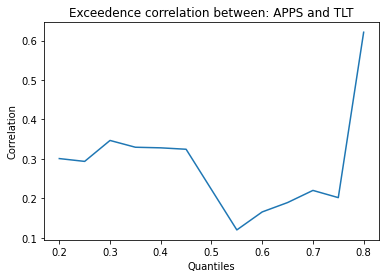

In [ ]:
plt.plot(qc, ec)
plt.title('Exceedence correlation between: ' + symbols[0] + ' and ' + symbols[1])
plt.xlabel('Quantiles')
plt.ylabel('Correlation')


## Copulas: 

There are 4 packages that can be used to model copulas:

1) Copulas (link: https://sdv.dev/Copulas/index.html) 

2) Copulalib (very old package, almost useless!) (link: https://pypi.org/project/copulalib/) 

3) PyCopula (link: https://blent-ai.github.io/pycopula/build/html/copula.html)

4) Copulae (link: https://copulae.readthedocs.io/en/latest/getting-started.html)

General steps in estimating copula:

Step #1: Download data and transform it into a necessary form

Step #2: Identify marginal distribution for each data series

Step #3: Transform marginal distribution to univariate distribution

Step #4: Use uniform distribution to fit a copula

NOTE, SOME PACKAGES CAN PERFORM STEP 2 - STEP 4 AUTOMATICALLY, THERE IS NO NEED FOR MANUAL COMPUTATION

In [ ]:
# Using the same data as in previous sections: 
# Plot marginal distributions: 
tt = symbols[0] + ' vs ' + symbols[1]
fig = px.scatter(stock_returns, x = 'APPS', y='TLT', width=700, height=500, trendline='ols', trendline_color_override='DeepPink', marginal_x='histogram', marginal_y='histogram', title=tt)
fig.show()

In [74]:
# Transforming marginal distributions to univariate distributions: 
apps_uniform = norm.cdf(stock_returns['APPS'])
tlt_uniform = norm.cdf(stock_returns['TLT'])
uniform_data = pd.DataFrame(np.stack([apps_uniform, tlt_uniform],axis=1), columns=['APPS', 'TLT'])
fig = px.scatter(uniform_data, x = 'APPS', y='TLT', width=700, height=500, trendline='ols', trendline_color_override='DeepPink', marginal_x='histogram', marginal_y='histogram', title='Hist')
fig.show()

In [10]:
# Gaussian copula:

gaussian_stock = GaussianMultivariate()
gaussian_stock.fit(stock_returns)

/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:4798: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/copulas/univariate/truncated_gaussian.py:43: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/copulas/univariate/truncated_gaussian.py:44: RuntimeWarning:

divide by zero encountered in double_scalars



In [49]:
u = np.linspace(0,1,10)
[u1, u2]=np.meshgrid(u,u);
data_for_visualization = np.concatenate((np.reshape(u2, (100,1)), np.reshape(u1, (100,1))),axis=1)
pdf_for_visualization = gaussian_stock.pdf(data_for_visualization)
z_reshaped = np.reshape(pdf_for_visualization, (10,10))

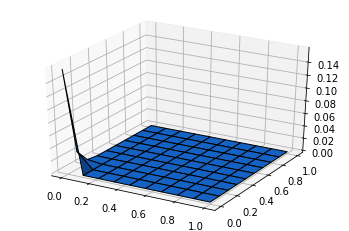

In [51]:
fig = plt.figure()
ax = fig.add_subplot( 111 , projection='3d')
ax.plot_surface(u1, u2, z_reshaped, color = (0.1, 0.5, 1), edgecolors='k' )